# Hurricane Research: EDA
This notebook will perform some intital EDA on the hurricane assignment from stats

Data is from http://weather.unisys.com/hurricane/atlantic/index.php, and is the year 2010 best of.

In [63]:
import numpy
import pandas
import seaborn
from datetime import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults

Data is imported as a no-header csv, and the column names are added

In [3]:
hurricane_raw = pandas.read_csv("hurricane.csv", header=None)
hurricane_raw.columns = [
                        'year', 'month', 'day', 
                        'hour', 'storm_year_id',
                        'name', 'latitude', 'longitude',
                        'wind_speed', 'pressure'
                        ]
hurricane_raw.shape

(5066, 10)

In [4]:
hurricane_raw.head()

,year,month,day,hour,storm_year_id,name,latitude,longitude,wind_speed,pressure
0,2000,6,7,18,1,NOT_NAMED,21.0,-93.0,25,0
1,2000,6,8,0,1,NOT_NAMED,20.9,-92.8,25,0
2,2000,6,8,6,1,NOT_NAMED,20.7,-93.1,25,0
3,2000,6,8,12,1,NOT_NAMED,20.8,-93.5,25,0
4,2000,6,23,0,2,NOT_NAMED,9.5,-19.8,25,0


We wish to look at only named storms, so we'll filter on that

In [5]:
has_name = hurricane_raw.name != "NOT_NAMED"
named = hurricane_raw[has_name]
named.shape

(4924, 10)

In [28]:
storm_matrix = named.get_values()
storm_dict = {}
for row in storm_matrix:
    key = row[5] + str(row[0]) 
    if key not in storm_dict:
        storm_dict[key] = []
    date = row[:4]
    data = row[6:]

    storm_dict[key].append(numpy.append(date, data))

`storm_dict` is now a dictonary, where each entry is an individual storm

In [7]:
def poly_want_a_storm(storm, degree=2, idx=0):
    """
    Fit a polynomial of regression to a single storm

    Arguments
    ---------
    storm -- a single storm from the storm dict. An array of small arrays
    degree -- polynomial degree; default of 2
    idx -- index of the miniarrays that is being fit
    """
    y = []
    x = []
    for i, time in enumerate(storm):
        y.append(i)
        x.append(time[idx])
    
    coeff = numpy.polyfit(y,x,degree)

    return coeff

Now we'll check to see if the function works.

In [8]:
poly_want_a_storm(storm_dict["ALBERTO2000"], idx=2)

array([ -1.58107632e-02,   1.34632985e+00,   4.43592159e+01])

It appears to produce the correct results. Now we can apply it to the entire data set and collect the coefficients.

In [9]:
coeffs = []
for k, v in storm_dict.items():
    c = poly_want_a_storm(v, degree=2, idx=2)
    coeffs.append(c)

coeffs = numpy.array(coeffs)

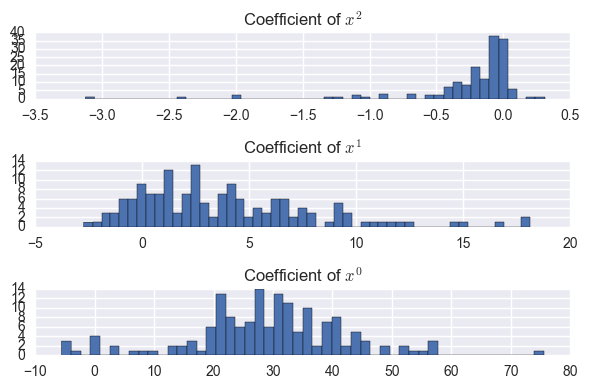

In [10]:
%matplotlib inline
deg = 2
nbin = 50

fig, axes = pyplot.subplots(3)
i = 0
for ax in axes:
        ax.hist(coeffs[:,i], nbin)
        ax.set_title("Coefficient of $x^{}$".format(deg - i))
        i += 1
fig.tight_layout()

In [11]:
coeffs = []
for k, v in storm_dict.items():
    c = poly_want_a_storm(v, degree=3, idx=2)
    coeffs.append(c)

coeffs = numpy.array(coeffs)

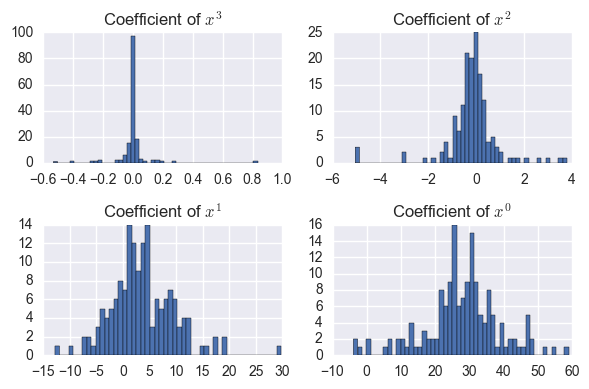

In [12]:
rows = 2
cols = 2
deg = 3
nbin = 50

fig, axes = pyplot.subplots(rows,cols)
i = 0
for row in axes:
    for ax in row:
        ax.hist(coeffs[:,i], nbin)
        ax.set_title("Coefficient of $x^{}$".format(deg - i))
        i += 1
fig.tight_layout()

# Time Series and ARIMA Model

In [32]:
def date_convert(array):
    return datetime(*array)

def generate_ts(storm):
    """
    Arguments
    ---------
    storm -- single storm from storm_dict
    """
    

In [87]:
test_storm = storm_dict["ALBERTO2000"]
times = [date_convert(x[:4]) for x in test_storm]

wind = [ float(x[6]) for x in test_storm]
ts = pandas.Series(wind, times).interpolate(method='time')

In [121]:
arima = ARIMA(ts, (1,2,2)).fit()
arima.aic

483.441409091473

In [131]:
def get_aic(ts, pdq):
    model = ARIMA(ts, pdq).fit()
    return model.aic


def auto_arima(ts, order):
    p = list(range(order[0] + 1))
    d = list(range(order[1] + 1))
    q = list(range(order[2] + 1))

    combinations = []
    for i in p:
        for j in d:
            for k in q:
                combinations.append((i,j,k))

    aic_min = None
    order_min = None
    for c in combinations:
        try:
            aic = get_aic(ts, c)
            if aic_min == None or aic_min > aic:
                aic_min = aic
                order_min = c
        except ValueError:
            pass
    

    return order_min, aic   

In [132]:
auto_arima(ts, (2,2,2))

((1, 2, 2), 486.80765766740353)